<a href="https://colab.research.google.com/github/OkoksNeDam/geoinformation-data-forecasting/blob/main/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting data from KEV station with CNN

## Import libraries

In [1]:
import torch
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam, SGD
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.impute import KNNImputer
from IPython.display import clear_output
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import random
import os
import copy

## Seed everything

In [107]:
SEED = 42

def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    tf.random.set_seed(seed)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

seed_everything(SEED)
g = torch.Generator()
g.manual_seed(SEED)

## Install data

In [3]:
import gdown
# Main data.
data_url         = 'https://drive.google.com/drive/folders/1HH70Q8NDpA3kPflrldGSdYRUs5tWxclI?usp=sharing'

links = [data_url]

# Downloading data.
for url in links:
    gdown.download_folder(url, quiet=True)

In [4]:
df_train, df_val, df_test = pd.read_csv('/content/data/train/train.csv'), pd.read_csv('/content/data/val/val.csv'), pd.read_csv('/content/data/test/test.csv')

In [5]:
df_train.head()

,ds,y
0,2003-01-01 01:00:00,1824.7
1,2003-01-01 02:00:00,1823.6
2,2003-01-01 03:00:00,1814.7
3,2003-01-01 04:00:00,1816.8
4,2003-01-01 05:00:00,1816.4


## Some functions

Define method for fill missing values

In [75]:
def fill_missing_values(dataframe, method):
    dataframe = dataframe.copy(deep=True)
    # fill with mean.
    if method == 'mean':
        return dataframe.fillna(dataframe.mean(numeric_only=True).round(1))
    # fill with median.
    if method == 'median':
        return dataframe.fillna(dataframe.median(numeric_only=True).round(1))
    # if there are nan left, fill with bfill.
    if method == 'ffill':
        return dataframe.fillna(method=method).fillna(method='bfill')
    # filling occurs with next values.
    # if there are nan left, fill with ffill.
    if method == 'bfill':
        return dataframe.fillna(method=method).fillna(method='ffill')
    # fill with backward interpolation.
    # if there are nan left, fill with forward.
    if method == 'interpolate_backward':
        return dataframe.apply(lambda col: col.interpolate(method ='linear', limit_direction ='backward')
                                              .interpolate(method ='linear', limit_direction ='forward') if col.name != "ds" else col)
    # fill with knn method.
    if method == 'knn':
        imputer = KNNImputer(n_neighbors=15)
        dataframe = dataframe.apply(lambda col: imputer.fit_transform(col.to_numpy().reshape(-1, 1)).T[0] if col.name != "ds" else col)
        return dataframe

    return dataframe

Method to split data into sequences

In [76]:
def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

Method for calculating smape metric

In [77]:
def calc_smape(actual, predicted) -> float:

    # Convert actual and predicted to numpy
    # array data type if not already
    if not all([isinstance(actual, np.ndarray),
                isinstance(predicted, np.ndarray)]):
        actual, predicted = np.array(actual), np.array(predicted)

    return np.mean(np.abs(predicted - actual) / ((np.abs(predicted) + np.abs(actual)) / 2) ) * 100

Visualization of metrics while training

In [78]:
sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})


def plot_metrics(train_losses, val_mape, val_smape):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train loss')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(val_mape) + 1), val_mape, label='val mape')
    axs[1].plot(range(1, len(val_smape) + 1), val_smape, label='val smape')
    axs[1].set_ylabel('mape/smape')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

In [79]:
def find_best_metric_by_filling_method(train, val, method):
    df_train_filled = fill_missing_values(train, method=method)
    df_val_filled = fill_missing_values(val, method=method)

    scaler = StandardScaler()
    df_train_filled.y = scaler.fit_transform(np.array(df_train_filled.y).reshape(-1, 1)).T[0]
    df_val_filled.y = scaler.transform(np.array(df_val_filled.y).reshape(-1, 1)).T[0]

    df_train_filled.index = pd.to_datetime(df_train_filled['ds'], format='%Y-%m-%d %H:%M:%S')
    df_val_filled.index = pd.to_datetime(df_val_filled['ds'], format='%Y-%m-%d %H:%M:%S')

    df_train_filled.drop(columns=['ds'], inplace=True)
    df_val_filled.drop(columns=['ds'], inplace=True)

    WINDOW_SIZE = 5

    X_train, y_train = df_to_X_y(df_train_filled, WINDOW_SIZE)
    X_val, y_val = df_to_X_y(df_val_filled, WINDOW_SIZE)

    model = Sequential()
    model.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(WINDOW_SIZE, 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1))

    model.compile(loss=MeanSquaredError(), optimizer=SGD(learning_rate=0.001, momentum=0.9), metrics=[RootMeanSquaredError()])
    model_history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20)

    return min(model_history.history['val_loss'])

## Find best method for filling missing values:

### 1. Fill NaN values with <i><b>mean</b></i> method.

In [63]:
mean_best_val_loss = find_best_metric_by_filling_method(df_train, df_val, 'mean')

Epoch 1/20
4553/4553 [==============================] - 12s 3ms/step - loss: 0.0251 - root_mean_squared_error: 0.1586 - val_loss: 0.0207 - val_root_mean_squared_error: 0.1440
Epoch 2/20
4553/4553 [==============================] - 11s 2ms/step - loss: 0.0158 - root_mean_squared_error: 0.1256 - val_loss: 0.0171 - val_root_mean_squared_error: 0.1307
Epoch 3/20
4553/4553 [==============================] - 11s 2ms/step - loss: 0.0149 - root_mean_squared_error: 0.1219 - val_loss: 0.0178 - val_root_mean_squared_error: 0.1333
Epoch 4/20
4553/4553 [==============================] - 11s 2ms/step - loss: 0.0145 - root_mean_squared_error: 0.1204 - val_loss: 0.0198 - val_root_mean_squared_error: 0.1406
Epoch 5/20
4553/4553 [==============================] - 11s 2ms/step - loss: 0.0143 - root_mean_squared_error: 0.1195 - val_loss: 0.0176 - val_root_mean_squared_error: 0.1326
Epoch 6/20
4553/4553 [==============================] - 11s 2ms/step - loss: 0.0141 - root_mean_squared_error: 0.1188 - val_l

In [64]:
print(f'Best val_loss for mean: ', mean_best_val_loss)

Best val_loss for mean:  0.013881873339414597


### 2. Fill NaN values with <i><b>median</b></i> method.

In [65]:
median_best_val_loss = find_best_metric_by_filling_method(df_train, df_val, 'median')

Epoch 1/20
4553/4553 [==============================] - 11s 2ms/step - loss: 0.0256 - root_mean_squared_error: 0.1599 - val_loss: 0.0236 - val_root_mean_squared_error: 0.1535
Epoch 2/20
4553/4553 [==============================] - 11s 2ms/step - loss: 0.0161 - root_mean_squared_error: 0.1269 - val_loss: 0.0180 - val_root_mean_squared_error: 0.1343
Epoch 3/20
4553/4553 [==============================] - 10s 2ms/step - loss: 0.0153 - root_mean_squared_error: 0.1235 - val_loss: 0.0194 - val_root_mean_squared_error: 0.1391
Epoch 4/20
4553/4553 [==============================] - 11s 2ms/step - loss: 0.0149 - root_mean_squared_error: 0.1220 - val_loss: 0.0211 - val_root_mean_squared_error: 0.1453
Epoch 5/20
4553/4553 [==============================] - 11s 3ms/step - loss: 0.0146 - root_mean_squared_error: 0.1210 - val_loss: 0.0204 - val_root_mean_squared_error: 0.1427
Epoch 6/20
4553/4553 [==============================] - 12s 3ms/step - loss: 0.0145 - root_mean_squared_error: 0.1202 - val_l

In [66]:
print(f'Best val_loss for median: ', median_best_val_loss)

Best val_loss for median:  0.014150653965771198


### 3. Fill NaN values with <i><b>ffill</b></i> method.

In [67]:
ffill_best_val_loss = find_best_metric_by_filling_method(df_train, df_val, 'ffill')

Epoch 1/20
4553/4553 [==============================] - 11s 2ms/step - loss: 0.0236 - root_mean_squared_error: 0.1538 - val_loss: 0.0224 - val_root_mean_squared_error: 0.1496
Epoch 2/20
4553/4553 [==============================] - 11s 2ms/step - loss: 0.0139 - root_mean_squared_error: 0.1180 - val_loss: 0.0183 - val_root_mean_squared_error: 0.1352
Epoch 3/20
4553/4553 [==============================] - 11s 2ms/step - loss: 0.0130 - root_mean_squared_error: 0.1139 - val_loss: 0.0187 - val_root_mean_squared_error: 0.1369
Epoch 4/20
4553/4553 [==============================] - 10s 2ms/step - loss: 0.0125 - root_mean_squared_error: 0.1119 - val_loss: 0.0190 - val_root_mean_squared_error: 0.1378
Epoch 5/20
4553/4553 [==============================] - 11s 2ms/step - loss: 0.0122 - root_mean_squared_error: 0.1107 - val_loss: 0.0152 - val_root_mean_squared_error: 0.1233
Epoch 6/20
4553/4553 [==============================] - 11s 2ms/step - loss: 0.0121 - root_mean_squared_error: 0.1098 - val_l

In [68]:
print(f'Best val_loss for ffill: ', ffill_best_val_loss)

Best val_loss for ffill:  0.013002852909266949


### 4. Fill NaN values with <i><b>bfill</b></i> method.

In [98]:
bfill_best_val_loss = find_best_metric_by_filling_method(df_train, df_val, 'bfill')

Epoch 1/20
4553/4553 [==============================] - 20s 4ms/step - loss: 0.0246 - root_mean_squared_error: 0.1569 - val_loss: 0.0206 - val_root_mean_squared_error: 0.1434
Epoch 2/20
4553/4553 [==============================] - 17s 4ms/step - loss: 0.0133 - root_mean_squared_error: 0.1154 - val_loss: 0.0170 - val_root_mean_squared_error: 0.1306
Epoch 3/20
4553/4553 [==============================] - 13s 3ms/step - loss: 0.0124 - root_mean_squared_error: 0.1113 - val_loss: 0.0171 - val_root_mean_squared_error: 0.1308
Epoch 4/20
4553/4553 [==============================] - 12s 3ms/step - loss: 0.0121 - root_mean_squared_error: 0.1099 - val_loss: 0.0185 - val_root_mean_squared_error: 0.1361
Epoch 5/20
4553/4553 [==============================] - 11s 3ms/step - loss: 0.0119 - root_mean_squared_error: 0.1092 - val_loss: 0.0154 - val_root_mean_squared_error: 0.1242
Epoch 6/20
4553/4553 [==============================] - 12s 3ms/step - loss: 0.0118 - root_mean_squared_error: 0.1086 - val_l

In [99]:
print(f'Best val_loss for bfill: ', bfill_best_val_loss)

Best val_loss for bfill:  0.013405246660113335


### 5. Fill NaN values with <i><b>interpolate_backward</b></i> method.

In [71]:
interpolate_backward_best_val_loss = find_best_metric_by_filling_method(df_train, df_val, 'interpolate_backward')

Epoch 1/20
4553/4553 [==============================] - 11s 2ms/step - loss: 0.0236 - root_mean_squared_error: 0.1535 - val_loss: 0.0195 - val_root_mean_squared_error: 0.1396
Epoch 2/20
4553/4553 [==============================] - 11s 2ms/step - loss: 0.0136 - root_mean_squared_error: 0.1164 - val_loss: 0.0166 - val_root_mean_squared_error: 0.1289
Epoch 3/20
4553/4553 [==============================] - 11s 3ms/step - loss: 0.0128 - root_mean_squared_error: 0.1133 - val_loss: 0.0168 - val_root_mean_squared_error: 0.1297
Epoch 4/20
4553/4553 [==============================] - 11s 2ms/step - loss: 0.0125 - root_mean_squared_error: 0.1117 - val_loss: 0.0187 - val_root_mean_squared_error: 0.1368
Epoch 5/20
4553/4553 [==============================] - 11s 2ms/step - loss: 0.0122 - root_mean_squared_error: 0.1106 - val_loss: 0.0166 - val_root_mean_squared_error: 0.1290
Epoch 6/20
4553/4553 [==============================] - 11s 2ms/step - loss: 0.0121 - root_mean_squared_error: 0.1098 - val_l

In [72]:
print(f'Best val_loss for interpolate_backward: ', interpolate_backward_best_val_loss)

Best val_loss for interpolate_backward:  0.013578114099800587


### 6. Fill NaN values with <i><b>knn</b></i> method.

In [73]:
knn_best_val_loss = find_best_metric_by_filling_method(df_train, df_val, 'knn')

Epoch 1/20
4553/4553 [==============================] - 11s 2ms/step - loss: 0.0249 - root_mean_squared_error: 0.1577 - val_loss: 0.0228 - val_root_mean_squared_error: 0.1508
Epoch 2/20
4553/4553 [==============================] - 10s 2ms/step - loss: 0.0160 - root_mean_squared_error: 0.1265 - val_loss: 0.0171 - val_root_mean_squared_error: 0.1308
Epoch 3/20
4553/4553 [==============================] - 11s 2ms/step - loss: 0.0151 - root_mean_squared_error: 0.1229 - val_loss: 0.0174 - val_root_mean_squared_error: 0.1321
Epoch 4/20
4553/4553 [==============================] - 11s 2ms/step - loss: 0.0147 - root_mean_squared_error: 0.1211 - val_loss: 0.0199 - val_root_mean_squared_error: 0.1411
Epoch 5/20
4553/4553 [==============================] - 11s 2ms/step - loss: 0.0144 - root_mean_squared_error: 0.1200 - val_loss: 0.0204 - val_root_mean_squared_error: 0.1430
Epoch 6/20
4553/4553 [==============================] - 11s 2ms/step - loss: 0.0142 - root_mean_squared_error: 0.1193 - val_l

In [74]:
print(f'Best val_loss for knn: ', knn_best_val_loss)

Best val_loss for knn:  0.014011465013027191


# Hyperparameter tuning

## Find best number of lags

In [108]:
FILLING_NAN_METHOD = 'ffill'

df_train_filled = fill_missing_values(df_train, method=FILLING_NAN_METHOD)
df_val_filled = fill_missing_values(df_val, method=FILLING_NAN_METHOD)

scaler = StandardScaler()
df_train_filled.y = scaler.fit_transform(np.array(df_train_filled.y).reshape(-1, 1)).T[0]
df_val_filled.y = scaler.transform(np.array(df_val_filled.y).reshape(-1, 1)).T[0]

df_train_filled.index = pd.to_datetime(df_train_filled['ds'], format='%Y-%m-%d %H:%M:%S')
df_val_filled.index = pd.to_datetime(df_val_filled['ds'], format='%Y-%m-%d %H:%M:%S')

df_train_filled.drop(columns=['ds'], inplace=True)
df_val_filled.drop(columns=['ds'], inplace=True)

### 1. Number of lags = <i><b>5</b></i>.

In [109]:
N_LAGS = 5

In [111]:
X_train, y_train = df_to_X_y(df_train_filled, N_LAGS)
X_val, y_val = df_to_X_y(df_val_filled, N_LAGS)

model = Sequential()
model.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(N_LAGS, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1))

model.compile(loss=MeanSquaredError(), optimizer=SGD(learning_rate=0.001, momentum=0.9), metrics=[RootMeanSquaredError()])
model_history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20)

Epoch 1/20
4553/4553 [==============================] - 12s 3ms/step - loss: 0.0265 - root_mean_squared_error: 0.1628 - val_loss: 0.0217 - val_root_mean_squared_error: 0.1473
Epoch 2/20
4553/4553 [==============================] - 12s 3ms/step - loss: 0.0142 - root_mean_squared_error: 0.1192 - val_loss: 0.0175 - val_root_mean_squared_error: 0.1324
Epoch 3/20
4553/4553 [==============================] - 11s 2ms/step - loss: 0.0131 - root_mean_squared_error: 0.1147 - val_loss: 0.0170 - val_root_mean_squared_error: 0.1304
Epoch 4/20
4553/4553 [==============================] - 11s 3ms/step - loss: 0.0126 - root_mean_squared_error: 0.1124 - val_loss: 0.0186 - val_root_mean_squared_error: 0.1365
Epoch 5/20
4553/4553 [==============================] - 12s 3ms/step - loss: 0.0124 - root_mean_squared_error: 0.1112 - val_loss: 0.0159 - val_root_mean_squared_error: 0.1262
Epoch 6/20
4553/4553 [==============================] - 14s 3ms/step - loss: 0.0121 - root_mean_squared_error: 0.1101 - val_l

In [112]:
train_losses = model_history.history['loss']
val_losses = model_history.history['val_loss']

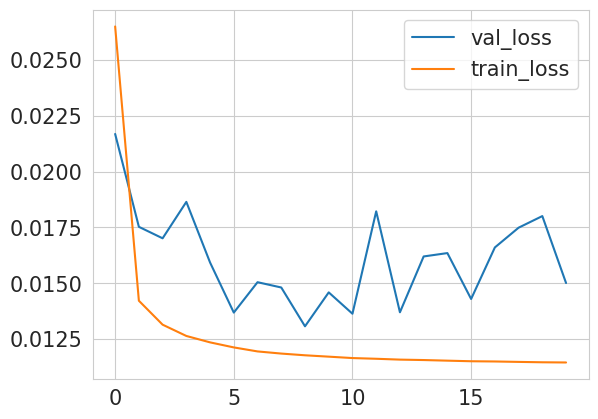

In [113]:
plt.plot(val_losses, label='val_loss')
plt.plot(train_losses, label='train_loss')
plt.legend()

In [114]:
print(f'Best val_loss for lags=5: ', round(min(val_losses), 5))

Best val_loss for lags=5:  0.01307


### 2. Number of lags = <i><b>10</b></i>.

In [115]:
N_LAGS = 10

In [117]:
X_train, y_train = df_to_X_y(df_train_filled, N_LAGS)
X_val, y_val = df_to_X_y(df_val_filled, N_LAGS)

model = Sequential()
model.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(N_LAGS, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1))

model.compile(loss=MeanSquaredError(), optimizer=SGD(learning_rate=0.001, momentum=0.9), metrics=[RootMeanSquaredError()])
model_history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20)

Epoch 1/20
4553/4553 [==============================] - 15s 3ms/step - loss: 0.0306 - root_mean_squared_error: 0.1749 - val_loss: 0.0282 - val_root_mean_squared_error: 0.1680
Epoch 2/20
4553/4553 [==============================] - 14s 3ms/step - loss: 0.0211 - root_mean_squared_error: 0.1454 - val_loss: 0.0248 - val_root_mean_squared_error: 0.1574
Epoch 3/20
4553/4553 [==============================] - 19s 4ms/step - loss: 0.0196 - root_mean_squared_error: 0.1402 - val_loss: 0.0241 - val_root_mean_squared_error: 0.1552
Epoch 4/20
4553/4553 [==============================] - 15s 3ms/step - loss: 0.0190 - root_mean_squared_error: 0.1379 - val_loss: 0.0279 - val_root_mean_squared_error: 0.1670
Epoch 5/20
4553/4553 [==============================] - 15s 3ms/step - loss: 0.0186 - root_mean_squared_error: 0.1364 - val_loss: 0.0263 - val_root_mean_squared_error: 0.1621
Epoch 6/20
4553/4553 [==============================] - 14s 3ms/step - loss: 0.0183 - root_mean_squared_error: 0.1353 - val_l

In [118]:
train_losses = model_history.history['loss']
val_losses = model_history.history['val_loss']

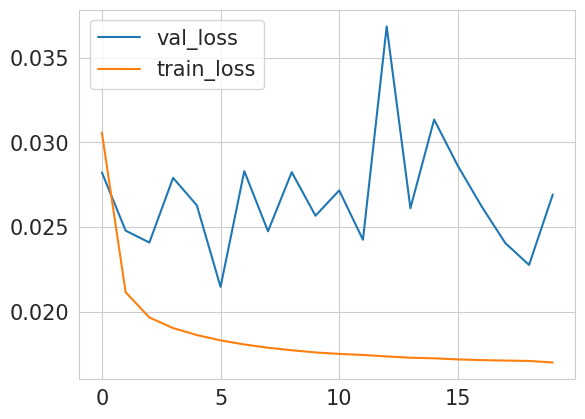

In [119]:
plt.plot(val_losses, label='val_loss')
plt.plot(train_losses, label='train_loss')
plt.legend()

In [120]:
print(f'Best val_loss for lags=10: ', round(min(val_losses), 5))

Best val_loss for lags=10:  0.02146


### 3. Number of lags = <i><b>20</b></i>.

In [121]:
N_LAGS = 20

In [122]:
X_train, y_train = df_to_X_y(df_train_filled, N_LAGS)
X_val, y_val = df_to_X_y(df_val_filled, N_LAGS)

model = Sequential()
model.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(N_LAGS, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1))

model.compile(loss=MeanSquaredError(), optimizer=SGD(learning_rate=0.001, momentum=0.9), metrics=[RootMeanSquaredError()])
model_history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=7)

Epoch 1/7
4553/4553 [==============================] - 22s 5ms/step - loss: 0.0264 - root_mean_squared_error: 0.1626 - val_loss: 0.0254 - val_root_mean_squared_error: 0.1593
Epoch 2/7
4553/4553 [==============================] - 21s 5ms/step - loss: 0.0174 - root_mean_squared_error: 0.1320 - val_loss: 0.0197 - val_root_mean_squared_error: 0.1405
Epoch 3/7
4553/4553 [==============================] - 21s 5ms/step - loss: 0.0164 - root_mean_squared_error: 0.1282 - val_loss: 0.0185 - val_root_mean_squared_error: 0.1359
Epoch 4/7
4553/4553 [==============================] - 22s 5ms/step - loss: 0.0160 - root_mean_squared_error: 0.1263 - val_loss: 0.0187 - val_root_mean_squared_error: 0.1369
Epoch 5/7
4553/4553 [==============================] - 23s 5ms/step - loss: 0.0157 - root_mean_squared_error: 0.1251 - val_loss: 0.0177 - val_root_mean_squared_error: 0.1331
Epoch 6/7
4553/4553 [==============================] - 21s 5ms/step - loss: 0.0154 - root_mean_squared_error: 0.1241 - val_loss: 0

In [123]:
train_losses = model_history.history['loss']
val_losses = model_history.history['val_loss']

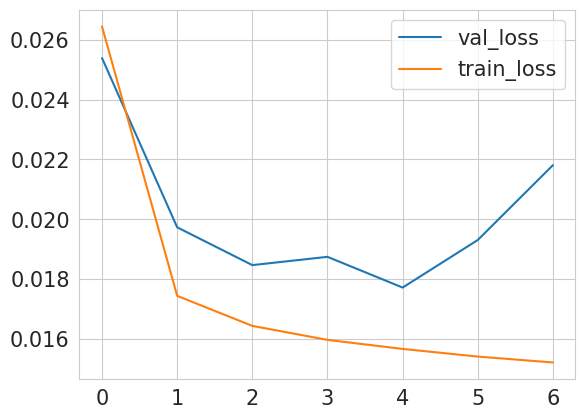

In [124]:
plt.plot(val_losses, label='val_loss')
plt.plot(train_losses, label='train_loss')
plt.legend()

In [125]:
print(f'Best val_loss for lags=20: ', round(min(val_losses), 5))

Best val_loss for lags=20:  0.01771


## Find best learning rate

In [126]:
FILLING_NAN_METHOD = 'ffill'

df_train_filled = fill_missing_values(df_train, method=FILLING_NAN_METHOD)
df_val_filled = fill_missing_values(df_val, method=FILLING_NAN_METHOD)

scaler = StandardScaler()
df_train_filled.y = scaler.fit_transform(np.array(df_train_filled.y).reshape(-1, 1)).T[0]
df_val_filled.y = scaler.transform(np.array(df_val_filled.y).reshape(-1, 1)).T[0]

df_train_filled.index = pd.to_datetime(df_train_filled['ds'], format='%Y-%m-%d %H:%M:%S')
df_val_filled.index = pd.to_datetime(df_val_filled['ds'], format='%Y-%m-%d %H:%M:%S')

df_train_filled.drop(columns=['ds'], inplace=True)
df_val_filled.drop(columns=['ds'], inplace=True)

N_LAGS = 5

X_train, y_train = df_to_X_y(df_train_filled, N_LAGS)
X_val, y_val = df_to_X_y(df_val_filled, N_LAGS)

### 1. learning rate = <i><b>1e-2</b></i>.

In [127]:
LEARNING_RATE = 1e-2

In [128]:
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(N_LAGS, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1))

model.compile(loss=MeanSquaredError(), optimizer=SGD(learning_rate=LEARNING_RATE, momentum=0.9), metrics=[RootMeanSquaredError()])
model_history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20)

Epoch 1/20
4553/4553 [==============================] - 12s 2ms/step - loss: 0.0160 - root_mean_squared_error: 0.1264 - val_loss: 0.0142 - val_root_mean_squared_error: 0.1193
Epoch 2/20
4553/4553 [==============================] - 12s 3ms/step - loss: 0.0125 - root_mean_squared_error: 0.1118 - val_loss: 0.0142 - val_root_mean_squared_error: 0.1190
Epoch 3/20
4553/4553 [==============================] - 11s 2ms/step - loss: 0.0122 - root_mean_squared_error: 0.1103 - val_loss: 0.0217 - val_root_mean_squared_error: 0.1472
Epoch 4/20
4553/4553 [==============================] - 12s 3ms/step - loss: 0.0120 - root_mean_squared_error: 0.1097 - val_loss: 0.0151 - val_root_mean_squared_error: 0.1230
Epoch 5/20
4553/4553 [==============================] - 11s 2ms/step - loss: 0.0120 - root_mean_squared_error: 0.1094 - val_loss: 0.0183 - val_root_mean_squared_error: 0.1352
Epoch 6/20
4553/4553 [==============================] - 13s 3ms/step - loss: 0.0119 - root_mean_squared_error: 0.1090 - val_l

In [129]:
train_losses = model_history.history['loss']
val_losses = model_history.history['val_loss']

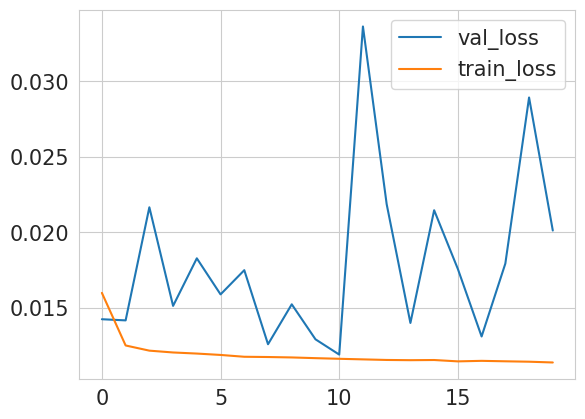

In [130]:
plt.plot(val_losses, label='val_loss')
plt.plot(train_losses, label='train_loss')
plt.legend()

In [131]:
print(f'Best val_loss for lr=1e-2: ', round(min(val_losses), 5))

Best val_loss for lr=1e-2:  0.0119


### 2. learning rate = <i><b>1e-3</b></i>.

In [132]:
LEARNING_RATE = 1e-3

In [133]:
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(N_LAGS, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1))

model.compile(loss=MeanSquaredError(), optimizer=SGD(learning_rate=LEARNING_RATE, momentum=0.9), metrics=[RootMeanSquaredError()])
model_history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20)

Epoch 1/20
4553/4553 [==============================] - 12s 2ms/step - loss: 0.0232 - root_mean_squared_error: 0.1523 - val_loss: 0.0190 - val_root_mean_squared_error: 0.1380
Epoch 2/20
4553/4553 [==============================] - 11s 3ms/step - loss: 0.0133 - root_mean_squared_error: 0.1154 - val_loss: 0.0171 - val_root_mean_squared_error: 0.1308
Epoch 3/20
4553/4553 [==============================] - 11s 2ms/step - loss: 0.0125 - root_mean_squared_error: 0.1120 - val_loss: 0.0171 - val_root_mean_squared_error: 0.1306
Epoch 4/20
4553/4553 [==============================] - 11s 2ms/step - loss: 0.0122 - root_mean_squared_error: 0.1104 - val_loss: 0.0186 - val_root_mean_squared_error: 0.1364
Epoch 5/20
4553/4553 [==============================] - 11s 2ms/step - loss: 0.0120 - root_mean_squared_error: 0.1095 - val_loss: 0.0152 - val_root_mean_squared_error: 0.1232
Epoch 6/20
4553/4553 [==============================] - 11s 2ms/step - loss: 0.0119 - root_mean_squared_error: 0.1089 - val_l

In [134]:
train_losses = model_history.history['loss']
val_losses = model_history.history['val_loss']

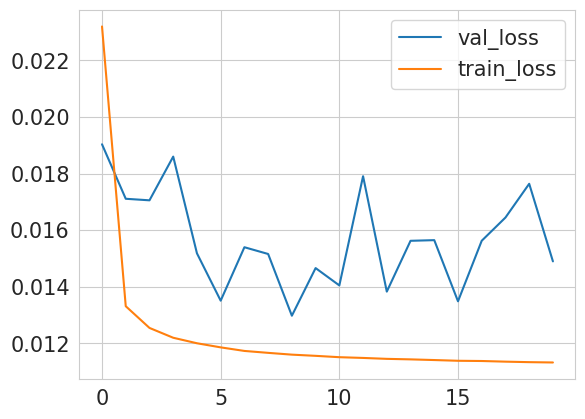

In [135]:
plt.plot(val_losses, label='val_loss')
plt.plot(train_losses, label='train_loss')
plt.legend()

In [136]:
print(f'Best val_loss for lr=1e-3: ', round(min(val_losses), 5))

Best val_loss for lr=1e-3:  0.01297


### 3. learning rate = <i><b>1e-4</b></i>.

In [137]:
LEARNING_RATE = 1e-4

In [138]:
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(N_LAGS, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1))

model.compile(loss=MeanSquaredError(), optimizer=SGD(learning_rate=LEARNING_RATE, momentum=0.9), metrics=[RootMeanSquaredError()])
model_history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20)

Epoch 1/20
4553/4553 [==============================] - 12s 3ms/step - loss: 0.0697 - root_mean_squared_error: 0.2641 - val_loss: 0.0291 - val_root_mean_squared_error: 0.1706
Epoch 2/20
4553/4553 [==============================] - 11s 3ms/step - loss: 0.0174 - root_mean_squared_error: 0.1320 - val_loss: 0.0239 - val_root_mean_squared_error: 0.1545
Epoch 3/20
4553/4553 [==============================] - 11s 3ms/step - loss: 0.0166 - root_mean_squared_error: 0.1287 - val_loss: 0.0218 - val_root_mean_squared_error: 0.1478
Epoch 4/20
4553/4553 [==============================] - 11s 2ms/step - loss: 0.0160 - root_mean_squared_error: 0.1266 - val_loss: 0.0215 - val_root_mean_squared_error: 0.1465
Epoch 5/20
4553/4553 [==============================] - 10s 2ms/step - loss: 0.0156 - root_mean_squared_error: 0.1249 - val_loss: 0.0204 - val_root_mean_squared_error: 0.1428
Epoch 6/20
4553/4553 [==============================] - 11s 2ms/step - loss: 0.0153 - root_mean_squared_error: 0.1235 - val_l

In [139]:
train_losses = model_history.history['loss']
val_losses = model_history.history['val_loss']

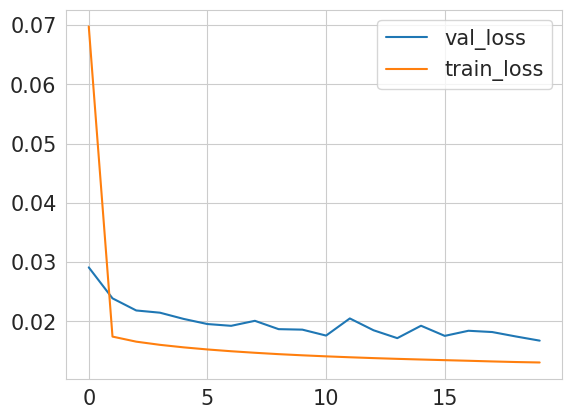

In [140]:
plt.plot(val_losses, label='val_loss')
plt.plot(train_losses, label='train_loss')
plt.legend()

In [141]:
print(f'Best val_loss for lr=1e-4: ', round(min(val_losses), 5))

Best val_loss for lr=1e-4:  0.01674


## Dropout

In [142]:
FILLING_NAN_METHOD = 'ffill'

df_train_filled = fill_missing_values(df_train, method=FILLING_NAN_METHOD)
df_val_filled = fill_missing_values(df_val, method=FILLING_NAN_METHOD)

scaler = StandardScaler()
df_train_filled.y = scaler.fit_transform(np.array(df_train_filled.y).reshape(-1, 1)).T[0]
df_val_filled.y = scaler.transform(np.array(df_val_filled.y).reshape(-1, 1)).T[0]

df_train_filled.index = pd.to_datetime(df_train_filled['ds'], format='%Y-%m-%d %H:%M:%S')
df_val_filled.index = pd.to_datetime(df_val_filled['ds'], format='%Y-%m-%d %H:%M:%S')

df_train_filled.drop(columns=['ds'], inplace=True)
df_val_filled.drop(columns=['ds'], inplace=True)

### 1. dropout = 0.1

In [143]:
N_LAGS = 5
LEARNING_RATE = 1e-2

X_train, y_train = df_to_X_y(df_train_filled, N_LAGS)
X_val, y_val = df_to_X_y(df_val_filled, N_LAGS)

model = Sequential()
model.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(N_LAGS, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.1))
model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1))

model.compile(loss=MeanSquaredError(), optimizer=SGD(learning_rate=LEARNING_RATE, momentum=0.9), metrics=[RootMeanSquaredError()])
model_history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20)

Epoch 1/20
4553/4553 [==============================] - 12s 3ms/step - loss: 0.0188 - root_mean_squared_error: 0.1370 - val_loss: 0.0199 - val_root_mean_squared_error: 0.1410
Epoch 2/20
4553/4553 [==============================] - 12s 3ms/step - loss: 0.0137 - root_mean_squared_error: 0.1170 - val_loss: 0.0158 - val_root_mean_squared_error: 0.1258
Epoch 3/20
4553/4553 [==============================] - 12s 3ms/step - loss: 0.0132 - root_mean_squared_error: 0.1150 - val_loss: 0.0153 - val_root_mean_squared_error: 0.1235
Epoch 4/20
4553/4553 [==============================] - 12s 3ms/step - loss: 0.0129 - root_mean_squared_error: 0.1136 - val_loss: 0.0197 - val_root_mean_squared_error: 0.1402
Epoch 5/20
4553/4553 [==============================] - 12s 3ms/step - loss: 0.0128 - root_mean_squared_error: 0.1132 - val_loss: 0.0330 - val_root_mean_squared_error: 0.1817
Epoch 6/20
4553/4553 [==============================] - 11s 2ms/step - loss: 0.0127 - root_mean_squared_error: 0.1125 - val_l

In [144]:
train_losses = model_history.history['loss']
val_losses = model_history.history['val_loss']

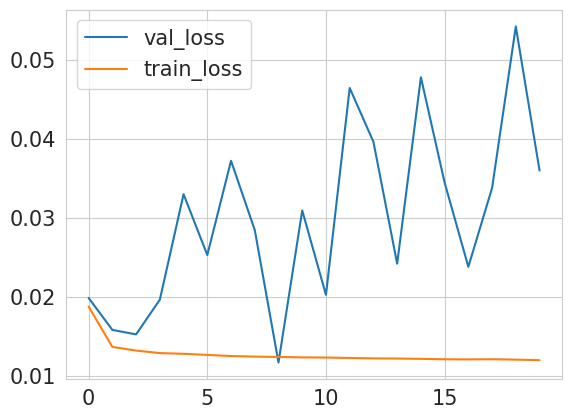

In [145]:
plt.plot(val_losses, label='val_loss')
plt.plot(train_losses, label='train_loss')
plt.legend()

In [146]:
print(f'Best val_loss for dropout=0.1: ', round(min(val_losses), 5))

Best val_loss for dropout=0.1:  0.01171


### 2. dropout = 0.25

In [147]:
N_LAGS = 5
LEARNING_RATE = 1e-2

X_train, y_train = df_to_X_y(df_train_filled, N_LAGS)
X_val, y_val = df_to_X_y(df_val_filled, N_LAGS)

model = Sequential()
model.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(N_LAGS, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))
model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1))

model.compile(loss=MeanSquaredError(), optimizer=SGD(learning_rate=LEARNING_RATE, momentum=0.9), metrics=[RootMeanSquaredError()])
model_history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20)

Epoch 1/20
4553/4553 [==============================] - 13s 3ms/step - loss: 0.0208 - root_mean_squared_error: 0.1442 - val_loss: 0.0222 - val_root_mean_squared_error: 0.1489
Epoch 2/20
4553/4553 [==============================] - 12s 3ms/step - loss: 0.0149 - root_mean_squared_error: 0.1221 - val_loss: 0.0252 - val_root_mean_squared_error: 0.1588
Epoch 3/20
4553/4553 [==============================] - 11s 2ms/step - loss: 0.0142 - root_mean_squared_error: 0.1192 - val_loss: 0.0151 - val_root_mean_squared_error: 0.1229
Epoch 4/20
4553/4553 [==============================] - 12s 3ms/step - loss: 0.0139 - root_mean_squared_error: 0.1177 - val_loss: 0.0313 - val_root_mean_squared_error: 0.1770
Epoch 5/20
4553/4553 [==============================] - 12s 3ms/step - loss: 0.0136 - root_mean_squared_error: 0.1168 - val_loss: 0.0629 - val_root_mean_squared_error: 0.2508
Epoch 6/20
4553/4553 [==============================] - 12s 3ms/step - loss: 0.0136 - root_mean_squared_error: 0.1165 - val_l

In [148]:
train_losses = model_history.history['loss']
val_losses = model_history.history['val_loss']

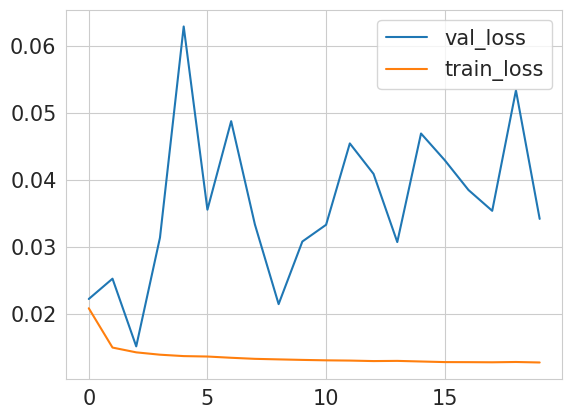

In [149]:
plt.plot(val_losses, label='val_loss')
plt.plot(train_losses, label='train_loss')
plt.legend()

In [150]:
print(f'Best val_loss for dropout=0.25: ', round(min(val_losses), 5))

Best val_loss for dropout=0.25:  0.01509


### 3. dropout = 0.5

In [151]:
N_LAGS = 5
LEARNING_RATE = 1e-2

X_train, y_train = df_to_X_y(df_train_filled, N_LAGS)
X_val, y_val = df_to_X_y(df_val_filled, N_LAGS)

model = Sequential()
model.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(N_LAGS, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))
model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1))

model.compile(loss=MeanSquaredError(), optimizer=SGD(learning_rate=LEARNING_RATE, momentum=0.9), metrics=[RootMeanSquaredError()])
model_history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20)

Epoch 1/20
4553/4553 [==============================] - 12s 3ms/step - loss: 0.0241 - root_mean_squared_error: 0.1553 - val_loss: 0.0622 - val_root_mean_squared_error: 0.2493
Epoch 2/20
4553/4553 [==============================] - 12s 3ms/step - loss: 0.0171 - root_mean_squared_error: 0.1308 - val_loss: 0.0848 - val_root_mean_squared_error: 0.2913
Epoch 3/20
4553/4553 [==============================] - 11s 3ms/step - loss: 0.0162 - root_mean_squared_error: 0.1274 - val_loss: 0.0895 - val_root_mean_squared_error: 0.2992
Epoch 4/20
4553/4553 [==============================] - 12s 3ms/step - loss: 0.0156 - root_mean_squared_error: 0.1248 - val_loss: 0.2300 - val_root_mean_squared_error: 0.4796
Epoch 5/20
4553/4553 [==============================] - 12s 3ms/step - loss: 0.0155 - root_mean_squared_error: 0.1245 - val_loss: 0.3226 - val_root_mean_squared_error: 0.5680
Epoch 6/20
4553/4553 [==============================] - 11s 3ms/step - loss: 0.0151 - root_mean_squared_error: 0.1231 - val_l

In [152]:
train_losses = model_history.history['loss']
val_losses = model_history.history['val_loss']

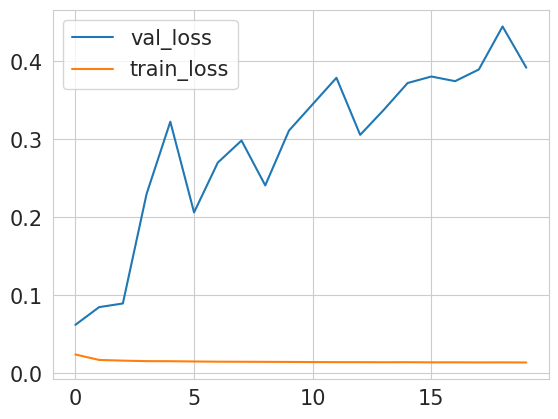

In [153]:
plt.plot(val_losses, label='val_loss')
plt.plot(train_losses, label='train_loss')
plt.legend()

In [154]:
print(f'Best val_loss for dropout=0.5: ', round(min(val_losses), 5))

Best val_loss for dropout=0.5:  0.06215


# Prediction on test data

In [155]:
FILLING_NAN_METHOD = 'ffill'

df_train_filled = fill_missing_values(df_train, method=FILLING_NAN_METHOD)
df_val_filled = fill_missing_values(df_val, method=FILLING_NAN_METHOD)
df_test_filled = fill_missing_values(df_test, method=FILLING_NAN_METHOD)

scaler = StandardScaler()
df_train_filled.y = scaler.fit_transform(np.array(df_train_filled.y).reshape(-1, 1)).T[0]
df_val_filled.y = scaler.transform(np.array(df_val_filled.y).reshape(-1, 1)).T[0]
df_test_filled.y = scaler.transform(np.array(df_test_filled.y).reshape(-1, 1)).T[0]

df_train_filled.index = pd.to_datetime(df_train_filled['ds'], format='%Y-%m-%d %H:%M:%S')
df_val_filled.index = pd.to_datetime(df_val_filled['ds'], format='%Y-%m-%d %H:%M:%S')
df_test_filled.index = pd.to_datetime(df_test_filled['ds'], format='%Y-%m-%d %H:%M:%S')

df_train_filled.drop(columns=['ds'], inplace=True)
df_val_filled.drop(columns=['ds'], inplace=True)
df_test_filled.drop(columns=['ds'], inplace=True)

In [156]:
N_LAGS = 5
LEARNING_RATE = 1e-2

X_train, y_train = df_to_X_y(df_train_filled, N_LAGS)
X_val, y_val = df_to_X_y(df_val_filled, N_LAGS)

model = Sequential()
model.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(N_LAGS, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.1))
model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1))

cp = ModelCheckpoint('best_model/', save_best_only=True, monitor='val_loss', mode='min')
model.compile(loss=MeanSquaredError(), optimizer=SGD(learning_rate=LEARNING_RATE, momentum=0.9), metrics=[RootMeanSquaredError()])
model_history = model.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=[cp], epochs=20)

Epoch 1/20
4553/4553 [==============================] - 14s 3ms/step - loss: 0.0184 - root_mean_squared_error: 0.1356 - val_loss: 0.0172 - val_root_mean_squared_error: 0.1311
Epoch 2/20
4553/4553 [==============================] - 12s 3ms/step - loss: 0.0135 - root_mean_squared_error: 0.1163 - val_loss: 0.0178 - val_root_mean_squared_error: 0.1336
Epoch 3/20
4553/4553 [==============================] - 13s 3ms/step - loss: 0.0131 - root_mean_squared_error: 0.1143 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1108
Epoch 4/20
4553/4553 [==============================] - 11s 3ms/step - loss: 0.0128 - root_mean_squared_error: 0.1133 - val_loss: 0.0160 - val_root_mean_squared_error: 0.1267
Epoch 5/20
4553/4553 [==============================] - 12s 3ms/step - loss: 0.0127 - root_mean_squared_error: 0.1127 - val_loss: 0.0337 - val_root_mean_squared_error: 0.1837
Epoch 6/20
4553/4553 [==============================] - 12s 3ms/step - loss: 0.0126 - root_mean_squared_error: 0.1122 - val_l

In [165]:
from tensorflow.keras.models import load_model
loaded_model = load_model('best_model/')

In [166]:
X_test, y_test = df_to_X_y(df_test_filled, N_LAGS)

test_predictions = loaded_model.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions':list(test_predictions), 'Actuals':np.squeeze(y_test)})
test_results

569/569 [==============================] - 1s 1ms/step


,Test Predictions,Actuals
0,2.401803,2.336613
1,2.343050,2.257902
2,2.275622,2.209770
3,2.216471,2.148613
4,2.173631,2.132192
...,...,...
18202,2.936815,3.021790
18203,2.936815,3.021790
18204,2.936815,3.021790
18205,2.936815,3.021790


In [167]:
print("test mse: ", mean_squared_error(test_results['Actuals'], test_results['Test Predictions']))
print(f"mape: {round(mean_absolute_percentage_error(test_results['Actuals'], test_results['Test Predictions']) * 100, 4)}")
print("test smape: ", calc_smape(test_results['Actuals'], test_results['Test Predictions']))

test mse:  0.023350582394661725
mape: 3.2168
test smape:  3.2798249366001055


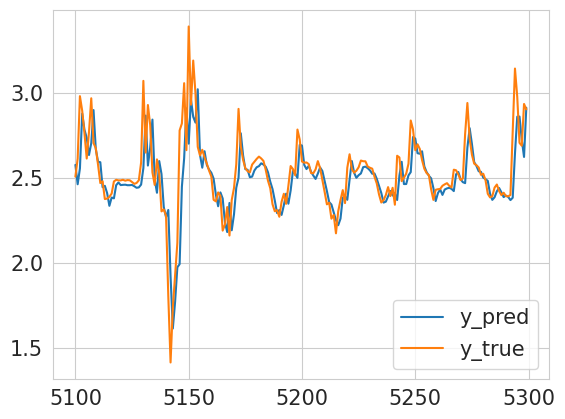

In [168]:
s = slice(5100, 5300)
plt.plot(test_results['Test Predictions'][s], label='y_pred')
plt.plot(test_results['Actuals'][s], label='y_true')
plt.legend()